# Exercise 1 — Solution

Build on the **demo** by exploring: (A) generation length, (B) numerical precision, and (C) KV cache. 

## 0) Environment guard
Avoid NumPy 2.x + TensorFlow wheel conflicts by disabling optional TF/Flax imports in `transformers`.

In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

## 1) Imports & globals
If the preferred model isn't available, we fall back to a tiny model to keep the notebook runnable everywhere.

In [2]:
import time
from typing import Dict, Any, List
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}; NumPy={np.__version__}; Torch={torch.__version__}")

PREFERRED_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

DEFAULT_PROMPT = (
        "Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural "
        "intelligence displayed by humans and animals. Leading AI textbooks define the field as the study "
        "of intelligent agents: any system that perceives its environment and takes actions that maximize "
        "its chance of achieving its goals. Colloquially, the term \"artificial intelligence\" is often "
        "used to describe machines that mimic cognitive functions that humans associate with the human mind, "
        "such as learning and problem-solving."
)


Device=cuda; NumPy=1.26.4; Torch=2.3.1.post300


## 2) Helpers 

In [ ]:
def _resolve_dtype(dtype_str: str, device: torch.device):
    if device.type == 'cpu' and dtype_str == 'float16':
        return torch.float32, 'float32 (forced on CPU)'
    return (torch.float16 if dtype_str == 'float16' else torch.float32), dtype_str

In [ ]:
def load_model_and_tokenizer(model_name: str, dtype_str: str = 'float16'):
    """Load tokenizer/model with chosen precision; return (tokenizer, model, model_used, dtype_used_label)."""
    dtype, label = _resolve_dtype(dtype_str, device)
    for name in [model_name]:
        try:
            tok = AutoTokenizer.from_pretrained(name, use_fast=True)
            mdl = AutoModelForCausalLM.from_pretrained(name, torch_dtype=dtype)
            mdl.to(device)
            mdl.eval()
            if tok.pad_token_id is None and tok.eos_token_id is not None:
                tok.pad_token = tok.eos_token
            return tok, mdl, name, label
        except Exception:
            continue
    raise RuntimeError('Could not load any model from preferred/fallback list.')

In [ ]:
def time_generate(model, tokenizer, prompt: str, max_new_tokens: int = 50, use_cache: bool = True,
                  num_warmup: int = 1, num_runs: int = 3) -> Dict[str, Any]:
    """Time model.generate and return metrics: total_latency_s, tokens_generated, tokens_per_sec, avg_latency_per_token_ms."""
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(model.device)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model.generate(input_ids, max_new_tokens=8, use_cache=use_cache)
    latencies, tokens_out = [], []
    with torch.no_grad():
        for _ in range(num_runs):
            t0 = time.perf_counter()
            out = model.generate(input_ids, max_new_tokens=max_new_tokens, use_cache=use_cache)
            t1 = time.perf_counter()
            latencies.append(t1 - t0)
            tokens_out.append(out.shape[-1] - input_ids.shape[-1])
    L = sum(latencies) / max(len(latencies), 1)
    TG = sum(tokens_out) / max(len(tokens_out), 1)
    TPS = (TG / L) if L > 0 else float('nan')
    LPT = (L / max(TG, 1e-9)) * 1000.0
    return {'total_latency_s': L, 'tokens_generated': TG, 'tokens_per_sec': TPS, 'avg_latency_per_token_ms': LPT}

In [3]:
def plot_xy(xs: List[float], ys: List[float], xlabel: str, ylabel: str, title: str):
    plt.figure()
    plt.plot(xs, ys, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

## 3) Baseline (same as demo)
Run one fixed setup as baseline: `max_new_tokens=50`, `float16`, `use_cache=True`.

In [4]:
tokenizer, model, MODEL_USED, DTYPE_USED = load_model_and_tokenizer(PREFERRED_MODEL, dtype_str='float16')
print(f"Loaded: {MODEL_USED} | dtype={DTYPE_USED}")
baseline = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
assert all(k in baseline for k in ['total_latency_s','tokens_generated','tokens_per_sec','avg_latency_per_token_ms'])
baseline

2025-08-21 23:20:18.266772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 23:20:18.280971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 23:20:18.299221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 23:20:18.304805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 23:20:18.317687: I tensorflow/core/platform/cpu_feature_guar

Loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0 | dtype=float16


{'total_latency_s': 0.9820365196598383,
 'tokens_generated': 50.0,
 'tokens_per_sec': 50.914603478615234,
 'avg_latency_per_token_ms': 19.640730393196765}

## 4) Exercise A — Generation Length vs Cost
Vary `max_new_tokens` and plot latency/throughput.

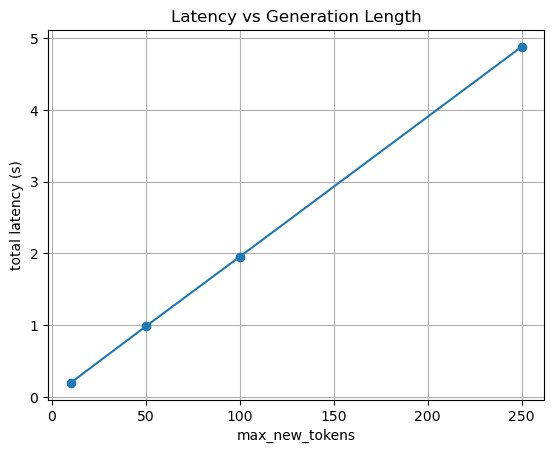

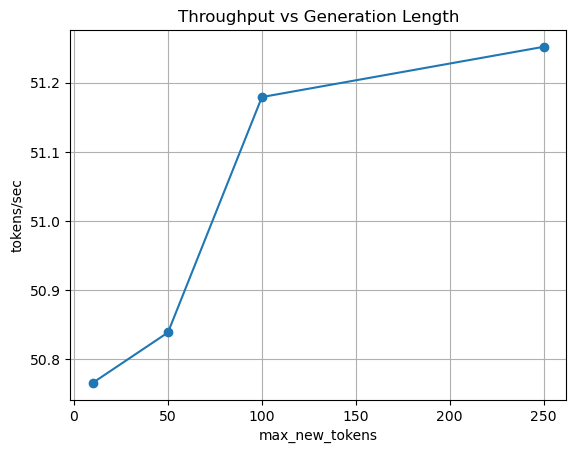

In [5]:
def run_for_varied_lengths():
    lengths = [10, 50, 100, 250]
    results_len = []
    for L in lengths:
        m = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=L, use_cache=True)
        results_len.append(m)
    latencies = [r['total_latency_s'] for r in results_len]
    throughputs = [r['tokens_per_sec'] for r in results_len]
    plot_xy(lengths, latencies, xlabel='max_new_tokens', ylabel='total latency (s)', title='Latency vs Generation Length')
    plot_xy(lengths, throughputs, xlabel='max_new_tokens', ylabel='tokens/sec', title='Throughput vs Generation Length')


run_for_varied_lengths()

## 5) Exercise B — Numerical Precision (float16 vs float32)
Reload for each precision with identical settings and compare.

In [6]:
def run_varied_precision():
    precisions = ['float16','float32']
    compare_precision = {}
    for p in precisions:
        tok, mod, used, dlab = load_model_and_tokenizer(PREFERRED_MODEL, dtype_str=p)
        compare_precision[p] = time_generate(mod, tok, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
    return compare_precision


compare_precision = run_varied_precision()

## 6) Exercise C — KV Cache On vs Off
Use the same model and toggle `use_cache`.

In [7]:
kv_results = {}
kv_results['use_cache=True'] = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
kv_results['use_cache=False'] = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=False)
kv_results

{'use_cache=True': {'total_latency_s': 0.997685762316299,
  'tokens_generated': 50.0,
  'tokens_per_sec': 50.115980290143064,
  'avg_latency_per_token_ms': 19.95371524632598},
 'use_cache=False': {'total_latency_s': 1.167668834348054,
  'tokens_generated': 50.0,
  'tokens_per_sec': 42.82036013054726,
  'avg_latency_per_token_ms': 23.353376686961077}}

## 7) (Optional) Compact summary table
Summarize the three ideas in a small table.

In [8]:
import pandas as pd
rows = []
rows.append({'label':'baseline (fp16, cache on)','dtype':'float16','use_cache':True,'max_new_tokens':50, **baseline})
rows.append({'label':'fp32, cache on','dtype':'float32','use_cache':True,'max_new_tokens':50, **compare_precision['float32']})
rows.append({'label':'fp16, cache off','dtype':'float16','use_cache':False,'max_new_tokens':50, **kv_results['use_cache=False']})
df = pd.DataFrame(rows)
df

,label,dtype,use_cache,max_new_tokens,total_latency_s,tokens_generated,tokens_per_sec,avg_latency_per_token_ms
0,"baseline (fp16, cache on)",float16,True,50,0.982037,50.0,50.914603,19.640730
1,"fp32, cache on",float32,True,50,1.129661,50.0,44.261063,22.593222
2,"fp16, cache off",float16,False,50,1.167669,50.0,42.820360,23.353377
